In [1]:
#Importing all the necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import urllib.request

from PIL import Image
import cv2

import warnings
warnings.filterwarnings("ignore") # To ignore any warnings


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Segmentaion model library
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()
from segmentation_models import Unet,get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

# Tensorflow Libray

#from tensorflow.keras.applications.mobilenet import preprocess_input, MobileNet
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D, Conv2D, Reshape, BatchNormalization
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import clear_session, log, epsilon
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import tensorflow as tf
print("Tensorflow Version: ", tf.__version__)

Segmentation Models: using `keras` framework.
Tensorflow Version:  2.5.0


# 1. Import the dataset.

In [2]:
# Changing the current working directory 
project_path = r"E:\Python\Residency 10\ACV Projects\Project 1"
data_path = r"E:\Python\Residency 10\ACV Projects\Project 1\ACV_Project_1_Dataset"
os.chdir(data_path)
os.getcwd()

'E:\\Python\\Residency 10\\ACV Projects\\Project 1\\ACV_Project_1_Dataset'

In [3]:
#Loading data
np_load_old = np.load

np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)

data = np.load('Dataset- Images.npy')

In [4]:
data.shape

(409, 2)

In [5]:
# Checking sample data
data[10][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.48, 'y': 0.10385756676557864},
   {'x': 0.7716666666666666, 'y': 0.6795252225519288}],
  'imageWidth': 600,
  'imageHeight': 337}]

In [6]:
data[10][0]

array([[[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [5, 5, 5],
        [6, 6, 6],
        [6, 6, 6]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [5, 5, 5],
        [6, 6, 6],
        [6, 6, 6]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [5, 5, 5],
        [5, 5, 5],
        [5, 5, 5]]], dtype=uint8)

# 2. Create features (images) and labels (mask) using that data.

In [7]:
# Setting image dimension
IMAGE_SIZE = 224
HEIGHT_CELLS = 28
WIDTH_CELLS = 28
#Defining transfer learning model
BACKBONE = "resnet34"

In [8]:
y = np.zeros((int(data.shape[0]), 28, 28), dtype=np.float32)
X = np.zeros((int(data.shape[0]), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
# Preprocessing data acordding to the chosen transfer learning model
preprocess_input_img = get_preprocessing(BACKBONE)

for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input_img(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * 28)
        x2 = int(i["points"][1]['x'] * 28)
        y1 = int(i["points"][0]['y'] * 28)
        y2 = int(i["points"][1]['y'] * 28)
        y[index][y1:y2, x1:x2] = 1

In [9]:
# Training and Masking data shape 
print("Features/Image data shape: ", X.shape)
print("Masking/Labels data shape:", y.shape)

Features/Image data shape:  (409, 224, 224, 3)
Masking/Labels data shape: (409, 28, 28)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 67.  61.  97.]
  [ 78.  72. 108.]
  [ 83.  77. 113.]
  ...
  [253. 122.  94.]
  [255. 121.  92.]
  [255. 121.  92.]]

 [[ 75.  69. 103.]
  [ 81.  75. 109.]
  [ 82.  76. 110.]
  ...
  [254. 119.  92.]
  [255. 119.  91.]
  [255. 119.  89.]]

 [[ 81.  75. 109.]
  [ 83.  77. 111.]
  [ 84.  78. 112.]
  ...
  [254. 118.  88.]
  [255. 119.  87.]
  [255. 118.  86.]]

 ...

 [[ 39.   5.   0.]
  [ 41.   6.   1.]
  [ 42.   7.   1.]
  ...
  [ 45.  43.  34.]
  [ 46.  47.  39.]
  [ 49.  50.  44.]]

 [[ 44.   8.   0.]
  [ 46.  10.   1.]
  [ 47.  11.   3.]
  ...
  [ 50.  42.  39.]
  [ 48.  43.  40.]
  [ 48.  43.  40.]]

 [[ 45.  10.   1.]
  [ 46.  10.   2.]
  [ 47.  11.   3.]
  ...
  [ 49.  42.  37.]
  [ 47.  42.  38.]
  [ 46.  43.  38.]]]



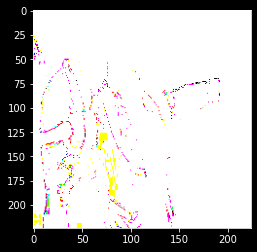

In [10]:
# Displaying image value and visual
n=56
print(X[n])
print()
plt.imshow(X[n])

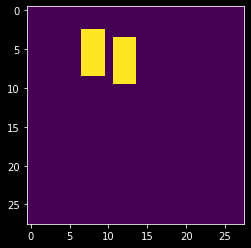

In [11]:
plt.imshow(y[n])

# 3. Mask detection model:

## a.Design a face mask detection model.

In [12]:
# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Training data shape: ", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape:  (327, 224, 224, 3)
Testing data shape: (82, 224, 224, 3)


In [13]:
# Randomly shuffle the training data
X_train, y_train = shuffle(X_train, y_train)

In [14]:
base_model = Unet(backbone_name='resnet34', encoder_weights='imagenet')
input_base_model = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
l1 = Conv2D(3, (1, 1))(input_base_model)
out = base_model(l1)
x1 = Conv2D(10, kernel_size =3,strides=2,padding = "same", activation="relu")(out)

x2= Conv2D(10, kernel_size=3,strides=2,padding = "same", activation="relu")(x1)

x3 = Conv2D(10, kernel_size=3,strides=2,padding = "same", activation="relu")(x2)
x4 = Conv2D(1, kernel_size=2,strides=2,padding = "same", activation="relu")(x3)

x5 = UpSampling2D()(x4)
x_out = Reshape((28,28))(x5)
model = Model(input_base_model, x_out, name=base_model.name)

## b.Design your own Dice Coefficient and Loss function.

In [15]:
#Dice Coefficient Function
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

In [16]:
#Loss Function
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.math.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [17]:
#Compiling Model
model.compile(optimizer='Adam', loss=loss, metrics=[dice_coefficient])

## c.Train, tune and test the model.

In [18]:
os.chdir(project_path)
os.getcwd()

'E:\\Python\\Residency 10\\ACV Projects\\Project 1'

In [19]:
checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, mode="min")
stop = EarlyStopping(monitor="val_loss", patience=7, mode="min")

In [20]:
#Training model
model.fit(X_train,y_train,batch_size=32,epochs=30,validation_data=(X_test, y_test), callbacks=[checkpoint,stop])

Epoch 1/30
11/11 [==============================] - 20s 893ms/step - loss: 2.6691 - dice_coefficient: 0.1222 - val_loss: 3.5527 - val_dice_coefficient: 0.0461

Epoch 00001: val_loss improved from inf to 3.55265, saving model to model-3.55.h5
Epoch 2/30
11/11 [==============================] - 4s 389ms/step - loss: 1.8419 - dice_coefficient: 0.2368 - val_loss: 2.1320 - val_dice_coefficient: 0.2179

Epoch 00002: val_loss improved from 3.55265 to 2.13197, saving model to model-2.13.h5
Epoch 3/30
11/11 [==============================] - 4s 389ms/step - loss: 1.5073 - dice_coefficient: 0.3121 - val_loss: 2.1604 - val_dice_coefficient: 0.2469

Epoch 00003: val_loss did not improve from 2.13197
Epoch 4/30
11/11 [==============================] - 4s 388ms/step - loss: 1.2295 - dice_coefficient: 0.4045 - val_loss: 2.3836 - val_dice_coefficient: 0.2539

Epoch 00004: val_loss did not improve from 2.13197
Epoch 5/30
11/11 [==============================] - 4s 391ms/step - loss: 0.9577 - dice_coeff

## b.Evaluate the model using testing data.

In [21]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 92ms/step - loss: 2.2386 - dice_coefficient: 0.2199


[2.2386465072631836, 0.21994195878505707]

# 4. Use the “Prediction image” as an input to your designed model and display the output of the image.

In [22]:
os.chdir(data_path)
os.getcwd()

'E:\\Python\\Residency 10\\ACV Projects\\Project 1\\ACV_Project_1_Dataset'

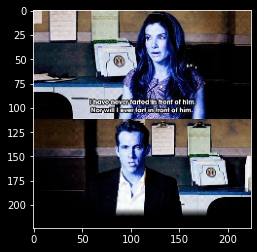

In [23]:
sample_image = "Prediction_Image.jpeg"
image = cv2.imread(sample_image)
image = cv2.resize(image, dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)

feat_scaled = preprocess_input_img(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.2), (IMAGE_SIZE,IMAGE_SIZE))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plt.imshow(out_image)

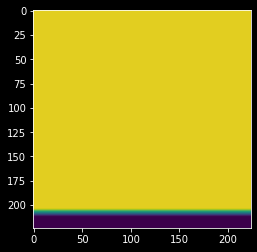

In [24]:
plt.imshow(pred_mask, alpha=.9) # Plotting masked image.

### Inference:- 
### 1. Its not predicting well as there's still rooom for improvment in UNet model. 
### 2. Better masking output can be obtained from this model by tunning it.

# To create an image dataset to be used by the AI team to build an image classifier data.

## 1. You are expected to curate the bounding box co-ordinates for each image. These are also called annotations.

In [25]:
#Loading images
faces = []
img_name = []
fpath = os.path.join(project_path, "training_real")

for f in os.listdir(fpath):
    ext = os.path.splitext(f)[1]
    i_n = os.path.splitext(f)[0]
    if ext == '.jpg' or ext == '.jpeg':
        img = cv2.imread(os.path.join(fpath, f))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.equalizeHist(img)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        faces.append(img)
        img_name.append(i_n)
    else:
        pass

faces = np.array(faces) 

In [26]:
faces.shape

(1081, 224, 224)

## 2. This task can be done using manual methods where you need to open each image and note the coordinates where the face located [though it is not recommended . This task can be easily done using an automation where you need to input the image in the  automation and the output is the coordinates of the face detected from the image. [this is highly recommended]. Also highlight how many faces detected in each image.

In [27]:
# download cascade classifier configuration
url = 'https://apmonitor.com/pds/uploads/Main/cascade.xml'
urllib.request.urlretrieve(url, 'cascade.xml')

('cascade.xml', <http.client.HTTPMessage at 0x200b136a1c0>)

In [28]:
faceCascade = cv2.CascadeClassifier('cascade.xml')

In [29]:
# Detecting annotations on each image.
a = []
b =[]
c =[]
d = []
t_f = []
for i in range(faces.shape[0]):
    # Identify faces
    bbox = faceCascade.detectMultiScale(faces[i], scaleFactor=1.05, minNeighbors=3, minSize=(30, 30))
    if bbox is ():
        t_f.append(0)
    else:
        t_f.append(bbox.shape[0])
        # display identified faces on original image
        for (x, y, w, h) in bbox:
            cv2.rectangle(faces[i],(x,y),(x+w,y+h),(255,255,0),3)
            a.append(x)
            b.append(y)
            c.append(w)
            d.append(h)

In [30]:
# Creating a DataFrame of annotations
df = pd.DataFrame(list(zip(a, b, c, d, t_f, img_name)), columns = ['X', 'Y', 'W', 'H', "Total Faces", "Image Name"])

In [31]:
df.sample(10)

,X,Y,W,H,Total Faces,Image Name
781,40,76,132,132,1,real_00782
928,31,42,166,166,2,real_00929
647,21,51,144,144,1,real_00648
717,44,54,148,148,2,real_00718
556,16,5,190,190,1,real_00557
686,16,38,168,168,1,real_00687
357,32,63,147,147,1,real_00358
795,41,83,126,126,1,real_00796
108,60,72,128,128,1,real_00109
339,38,67,150,150,1,real_00340


In [32]:
os.chdir(project_path)
os.getcwd()

'E:\\Python\\Residency 10\\ACV Projects\\Project 1'

In [33]:
df.to_csv('Annotations.csv')

## 3. Comment on the challenges faced during this task.

### Inferences:- 
### 1. Manual annoting each image individually can be done usinf LabelImg library.
### 2. Doing maually would consume huge amount of time according to images.
### 3. Automation can be done using the casade classifier from opencv Library which is based on Viola-Jones Detection method.
### 4. Using the pretrained file from classifer makes it easy to create annotations. Some images are skiped as the model fails to identify.
### 5. This remaining images can be done manually.